In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
data_path = os.path.join("/Users/hemanth/Downloads/", 'aclImdb')

In [4]:
def prepare_data(data_path, seed):

    #prepare the training data
    train_text = []
    train_labels = []
    count = 0
    for category in ['pos','neg']:
        train_path  = os.path.join(data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_text.append(f.read())
                train_labels.append(0 if category=='neg' else 1)

    #preparing the testing data

    test_text = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_text.append(f.read())
                test_labels.append(0 if category=='neg' else 1)


#shuffle the data
    random.seed(seed)
    random.shuffle(train_text)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_text, np.array(train_labels)), (test_text, np.array(test_labels)))
    


In [5]:
(train_text, train_labels), (test_text, test_labels) = prepare_data(data_path=data_path, seed=1234)

In [6]:
def number_of_words(train_text):
    words = [len(s.split()) for s in train_text]
    return np.median(words)


In [7]:
number_of_words(train_text)

174.0

In [8]:
def print_sample_length_distribution(train_text):
    plt.hist([len(s) for s in train_text], 20)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

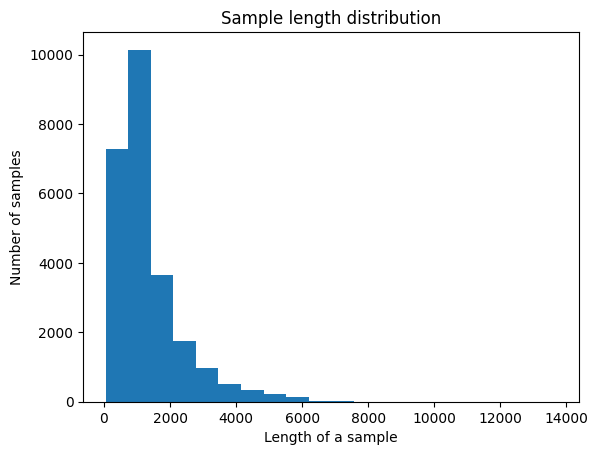

In [9]:
print_sample_length_distribution(train_text)

vectorising the data for feeding into the model

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


NGRAM_RANGE = (1, 2)


TOP_K = 20000


TOKEN_MODE = 'word'


MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):

    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    x_train = vectorizer.fit_transform(train_texts)


    x_val = vectorizer.transform(val_texts)


    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [12]:
x_train, x_test = ngram_vectorize(train_text, train_labels, test_text)

/Users/hemanth/opt/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [13]:

print(x_train.shape)
print(x_test.shape)

(25000, 20000)
(25000, 20000)


In [14]:
from sklearn import svm
from sklearn.metrics import classification_report

classifire_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifire_linear.fit(x_train, train_labels)
t1=time.time()
prediction_linear = classifire_linear.predict(x_test)
t2 = time.time()

time_train = t1-t0
time_test = t2-t1

print("Training time: %fs, Prediction time: %fs" %(time_train, time_test))
report = classification_report(test_labels, prediction_linear, output_dict=True)




Training time: 479.246281s, Prediction time: 448.593259s


In [18]:
from sklearn.metrics import accuracy_score

In [19]:
print(accuracy_score(prediction_linear, test_labels))

0.89896


In [20]:
params = classifire_linear.get_params()

In [21]:
print(params)

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
